# **Introdução Geral**

No projeto o objetivo principal é trabalhar com Processamento de Linguagem Natural (PLN) para identificar categorias gramaticais (tags) em textos em português. Eu estou usando técnicas modernas, como modelos de linguagem baseados em BERT, para realizar a tarefa de etiquetagem de sequência. Durante o processo, eu também incluo análises detalhadas dos dados, como a distribuição das tags e as coocorrências entre elas, para entender melhor o comportamento tanto do modelo quanto do conjunto de dados.

A seguir, vou detalhar cada trecho do código para explicar como cheguei às soluções implementadas.


In [21]:
import os
import itertools
from collections import Counter, defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

## **Upload do Dataset e Tratamento**

Este trecho configura o diretório onde os dados estão armazenados e o modelo que será usado. Além disso, implementa uma função para carregar o dataset, extraindo as sentenças e suas respectivas tags. O objetivo é preparar os dados para serem utilizados nas próximas etapas do projeto.


In [20]:
# Configurações globais
DATA_DIR = "./macmorpho-v3"
MODEL_NAME = "lisaterumi/postagger-portuguese"


# Função para carregar os dados
def load_data(file_path):
    """
    Carrega sentenças e tags do arquivo fornecido.

    Args:
        file_path (str): Caminho do arquivo.

    Returns:
        sentences (list): Lista de sentenças (strings).
        true_tags (list): Lista de listas com as tags correspondentes.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    sentences, true_tags = [], []
    for line in lines:
        word_tag_pairs = line.strip().split()
        if word_tag_pairs:
            sentence = " ".join(word.split("_")[0] for word in word_tag_pairs)
            tags = [word.split("_")[1] for word in word_tag_pairs]
            sentences.append(sentence)
            true_tags.append(tags)

    return sentences, true_tags

train_path = os.path.join(DATA_DIR, "macmorpho-test.txt")
sentences, true_tags = load_data(train_path)

## Visualização da Distribuição de Tags

Este trecho do código cria um gráfico de barras horizontais para visualizar a frequência de cada tag no dataset. A distribuição das tags é ordenada em ordem crescente e apresentada com uma paleta de cores para facilitar a interpretação. Essa visualização é útil para identificar as tags mais comuns e entender a composição do corpus antes do treinamento do modelo.


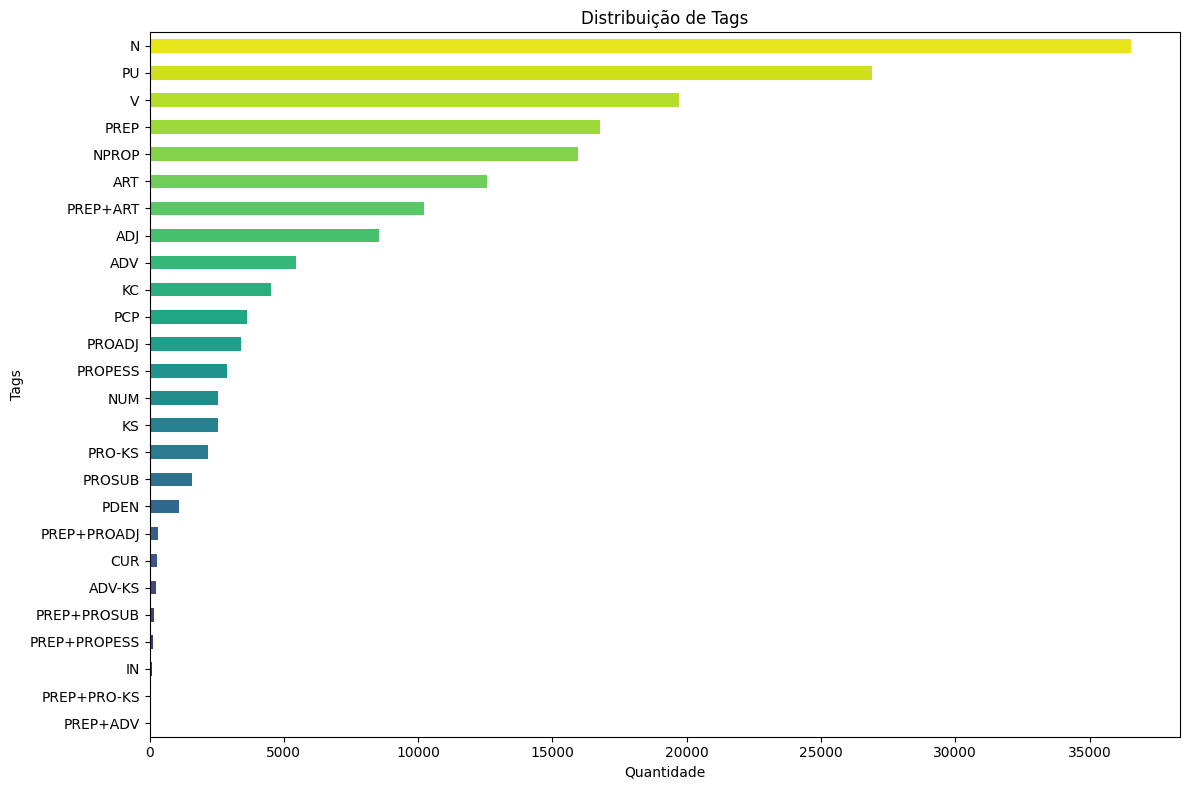

In [22]:
# Função para exibir a distribuição de tags como gráfico de pizza
def plot_tag_distribution(true_tags, output_path="tag_distribution_barh.png"):
    """
    Plota a distribuição de tags como um gráfico de barras horizontais.

    Args:
        true_tags (list): Lista de listas com as tags reais.
        output_path (str): Caminho para salvar a figura.
    """
    tag_counts = Counter(itertools.chain.from_iterable(true_tags))
    tag_counts = pd.Series(tag_counts).sort_values(ascending=True)  # Ordenar por valor

    plt.figure(figsize=(12, 8))
    tag_counts.plot(kind="barh", color=sns.color_palette("viridis", len(tag_counts)))
    plt.xlabel("Quantidade")
    plt.ylabel("Tags")
    plt.title("Distribuição de Tags")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

plot_tag_distribution(true_tags)

## Matriz de Coocorrência de Tags com Gráfico de Bolhas

Este trecho do código cria um gráfico de bolhas para visualizar a coocorrência de tags no dataset. Cada bolha representa a frequência com que um par de tags aparece juntas, sendo o tamanho e a cor das bolhas proporcionais à quantidade de coocorrências. Essa visualização é útil para identificar relações ou padrões entre diferentes tags, ajudando a entender melhor as interações no corpus.


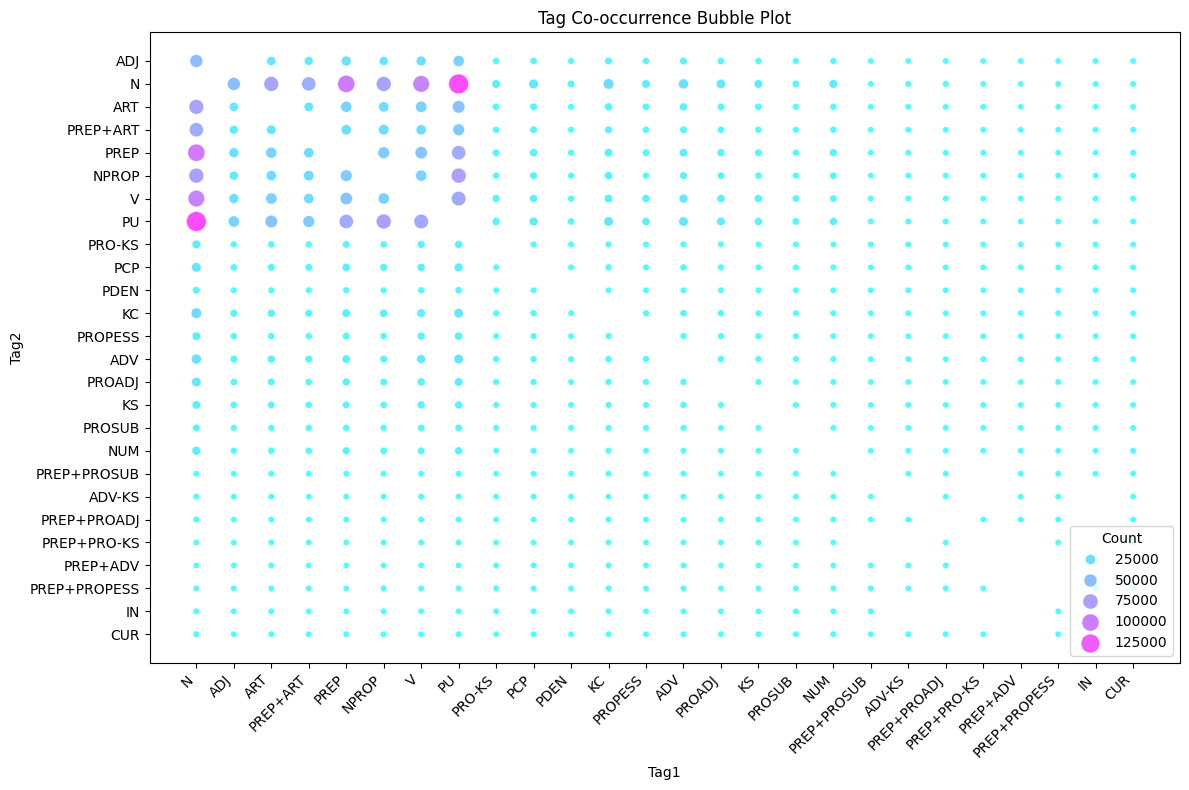

In [23]:
# Função para gerar a matriz de coocorrência como gráfico de bolhas
def plot_cooccurrence_matrix(true_tags, output_path="cooccurrence_matrix_bubble.png"):
    """
    Plota a matriz de coocorrência de tags como um gráfico de bolhas.

    Args:
        true_tags (list): Lista de listas com as tags reais.
        output_path (str): Caminho para salvar a figura.
    """
    tag_pairs_count = Counter()
    for tags in true_tags:
        for tag1, tag2 in itertools.combinations(tags, 2):
            if tag1 != tag2:
                tag_pairs_count[(tag1, tag2)] += 1
                tag_pairs_count[(tag2, tag1)] += 1

    # Preparar dados para o gráfico
    data = []
    for (tag1, tag2), count in tag_pairs_count.items():
        data.append({"Tag1": tag1, "Tag2": tag2, "Count": count})

    df = pd.DataFrame(data)

    # Criar o gráfico de bolhas
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x="Tag1",
        y="Tag2",
        size="Count",
        hue="Count",
        sizes=(20, 200),
        palette="cool",
        alpha=0.7,
        edgecolor="w",
    )
    plt.title("Tag Co-occurrence Bubble Plot")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

plot_cooccurrence_matrix(true_tags)

## Carregamento do Modelo e Tokenizador

Este trecho do código implementa uma função para carregar o modelo e o tokenizador usando a biblioteca Hugging Face. O modelo é responsável por realizar a tarefa de classificação de tokens, enquanto o tokenizador converte as frases em representações que o modelo pode interpretar. A função facilita o carregamento ao encapsular esses passos em um único ponto, retornando ambos os objetos para serem usados nas próximas etapas.


In [5]:
# Carregar modelo e tokenizer
def load_model_and_tokenizer(model_name):
    """
    Carrega o modelo e o tokenizador do Hugging Face.

    Args:
        model_name (str): Nome do modelo.

    Returns:
        tokenizer, model: Tokenizer e modelo carregados.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    return tokenizer, model

tokenizer, model = load_model_and_tokenizer(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/678k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

## Função para Prever Tags

Este trecho do código implementa uma função que utiliza o modelo treinado para prever as tags de uma sentença. A sentença é tokenizada pelo tokenizador, processada pelo modelo para gerar as predições, e as tags correspondentes são mapeadas de volta a seus rótulos originais. A função também filtra tokens especiais para garantir que apenas as palavras relevantes recebam tags. Essa função é essencial para testar o modelo em novas sentenças.

In [6]:
# Função para prever tags
def predict_tags(sentence, tokenizer, model):
    """
    Prediz as tags para uma sentença.

    Args:
        sentence (str): Sentença de entrada.
        tokenizer: Tokenizador Hugging Face.
        model: Modelo Hugging Face.

    Returns:
        predicted_tags (list): Lista de tags previstas.
    """
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)
    id_to_tag = model.config.id2label
    predicted_tags = [id_to_tag.get(int(idx), "O") for idx in predictions[0]]
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    pred_tags_filtered = [tag for token, tag in zip(tokens, predicted_tags) if token not in tokenizer.all_special_tokens]
    return pred_tags_filtered

predicted_tags = [predict_tags(sentence, tokenizer, model) for sentence in sentences]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Cálculo e Visualização de Métricas

Este trecho implementa funções para calcular métricas como acurácia, precisão, recall e F1-score para cada tag, além de gerar um gráfico comparativo dessas métricas. A função `calculate_metrics` realiza os cálculos com base nas tags reais e previstas, enquanto `plot_metrics` cria um gráfico de barras que facilita a comparação das métricas para cada tag. Esse gráfico ajuda a identificar o desempenho do modelo em diferentes categorias, destacando suas forças e fraquezas.

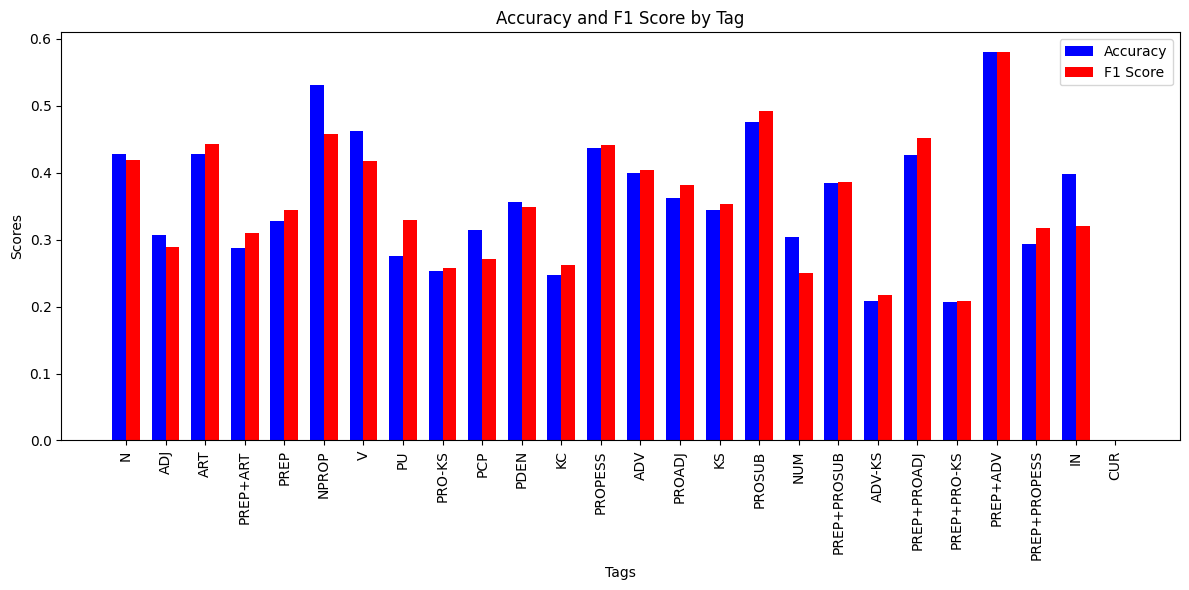

In [14]:
# Função para calcular métricas
def calculate_metrics(true_tags, predicted_tags):
    """
    Calcula métricas como precisão, recall e F1-score por tag.

    Args:
        true_tags (list): Lista de listas com as tags reais.
        predicted_tags (list): Lista de listas com as tags previstas.

    Returns:
        metrics_df (DataFrame): DataFrame com as métricas calculadas.
    """
    correct_counts = defaultdict(int)
    total_counts = defaultdict(int)
    true_positives = defaultdict(int)
    false_positives = defaultdict(int)
    false_negatives = defaultdict(int)

    for pred, true in zip(predicted_tags, true_tags):
        for p, t in zip(pred, true):
            total_counts[t] += 1
            if p == t:
                correct_counts[t] += 1
                true_positives[t] += 1
            else:
                false_positives[p] += 1
                false_negatives[t] += 1

    tags, accuracies, f1_scores = [], [], []
    for tag, total in total_counts.items():
        accuracy = correct_counts[tag] / total if total > 0 else 0
        precision = true_positives[tag] / (true_positives[tag] + false_positives[tag]) if true_positives[tag] + false_positives[tag] > 0 else 0
        recall = true_positives[tag] / total if total > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        tags.append(tag)
        accuracies.append(accuracy)
        f1_scores.append(f1)

    metrics_df = pd.DataFrame({"Tag": tags, "Accuracy": accuracies, "F1 Score": f1_scores})
    return metrics_df

def plot_metrics(metrics_df, output_path="metrics_plot.png"):
    """
    Plota as métricas (Accuracy e F1 Score) para cada tag.

    Args:
        metrics_df (DataFrame): DataFrame contendo as métricas por tag.
        output_path (str): Caminho para salvar o gráfico.
    """
    tags = metrics_df["Tag"]
    accuracies = metrics_df["Accuracy"]
    f1_scores = metrics_df["F1 Score"]

    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35  # Largura das barras
    indices = range(len(tags))

    # Barras de Accuracy e F1 Score
    ax.bar([i - width / 2 for i in indices], accuracies, width, label="Accuracy", color="blue")
    ax.bar([i + width / 2 for i in indices], f1_scores, width, label="F1 Score", color="red")

    # Configurações do gráfico
    ax.set_xlabel("Tags")
    ax.set_ylabel("Scores")
    ax.set_title("Accuracy and F1 Score by Tag")
    ax.set_xticks(indices)
    ax.set_xticklabels(tags, rotation=90)
    ax.legend()

    # Salvar e exibir o gráfico
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


metrics_df = calculate_metrics(true_tags, predicted_tags)
plot_metrics(metrics_df, output_path="metrics_plot.png")

O gráfico acima mostra o desempenho do modelo em termos de precisão e F1-Score para cada classe gramatical. Tags mais frequentes, como **N** (substantivo) e **V** (verbo), apresentaram os melhores resultados, refletindo a facilidade do modelo em aprender padrões amplamente representados no corpus. Em contrapartida, tags como **PREP+PROPESS** (preposição + pronome pessoal) e **IN** (interjeição) tiveram os piores desempenhos, indicando a dificuldade do modelo com classes menos frequentes ou mais específicas.

Observa-se também uma discrepância entre precisão e F1-Score em algumas classes, como **PROPESS** (pronome pessoal), sugerindo um número elevado de falsos positivos ou negativos. Essas inconsistências podem ser atribuídas ao desequilíbrio no corpus, que favorece classes mais comuns e deixa classes raras sub-representadas.


## Testes



### Teste com Frases Personalizadas

Este trecho do código implementa uma função para testar o modelo com frases fornecidas. A função processa cada frase da lista, gerando as predições correspondentes para as palavras. Em seguida, exibe a frase original e as tags previstas. Esse teste permite validar o desempenho do modelo em novos exemplos e verificar a correspondência das predições com o contexto das frases.

Frase: O cachorro está correndo no parque.
Tags previstas: ['ART', 'N', 'V', 'V', 'PREP', 'N']

Frase: A lua brilha no céu à noite.
Tags previstas: ['ART', 'N', 'V', 'PREP', 'N', 'PREP', 'ADV']

Frase: Estou aprendendo a programar modelos de linguagem.
Tags previstas: ['V', 'V', 'PREP', 'V', 'N', 'PREP', 'N']

In [28]:
def test_custom_sentences(custom_sentences, tokenizer, model):
    """
    Testa o modelo em frases personalizadas fornecidas pelo usuário.

    Args:
        custom_sentences (list): Lista de frases fornecidas para teste.
        tokenizer: Tokenizador Hugging Face.
        model: Modelo Hugging Face.
    """

    for sentence in custom_sentences:
        predicted_tags = predict_tags(sentence, tokenizer, model)
        print(f"\nFrase: {sentence}")
        print(f"Tags previstas: {predicted_tags}")


custom_sentences = ["O cachorro está correndo no parque", "A lua brilha no céu à noite", "Estou aprendendo a programar modelos de linguagem"]
test_custom_sentences(custom_sentences, tokenizer, model)


Frase: O cachorro está correndo no parque
Tags previstas: ['ART', 'N', 'V', 'V', 'PREP+ART', 'N']

Frase: A lua brilha no céu à noite
Tags previstas: ['ART', 'N', 'V', 'PREP+ART', 'N', 'PREP+ART', 'N']

Frase: Estou aprendendo a programar modelos de linguagem
Tags previstas: ['V', 'V', 'V', 'V', 'PREP', 'V', 'V', 'N', 'PREP', 'N']


No trecho da imagem anterior, o código testa o modelo em frases personalizadas, como "O cachorro está correndo no parque". Para cada frase, as tags previstas são exibidas, permitindo avaliar como o modelo classifica as palavras. No resultado, vemos que as tags previstas seguem o contexto das frases, mostrando que o modelo consegue identificar corretamente as funções das palavras. Isso valida sua capacidade de generalizar para frases fora do conjunto de treinamento.
 Essa discrepância sugere que o modelo pode ter dificuldades em lidar com frases que não estão alinhadas diretamente ao contexto do treinamento ou que apresentam construções mais desafiadoras.


### Avaliação por Comprimento de Sentença e Resultados

Este trecho avalia o desempenho do modelo em frases de diferentes comprimentos (curtas, médias e longas). As frases são agrupadas com base no número de palavras, e a acurácia é calculada para cada grupo. No resultado, percebemos que o modelo tem melhor desempenho em frases curtas (acurácia de 0.21) e desempenho mais fraco em frases médias (0.14) e longas (0.03). Isso pode indicar que o modelo tem dificuldades em lidar com frases mais complexas, possivelmente devido à dependência de contexto mais amplo nesses casos.

In [29]:
# **Avaliação por Comprimento de Sentença**
def evaluate_by_sentence_length(sentences, true_tags, predicted_tags):
    """
    Avalia o desempenho do modelo com base no comprimento das frases.

    Args:
        sentences (list): Lista de frases.
        true_tags (list): Lista de tags reais.
        predicted_tags (list): Lista de tags previstas.

    Returns:
        None
    """
    length_buckets = {'curtas': [], 'medias': [], 'longas': []}
    for sentence, true, pred in zip(sentences, true_tags, predicted_tags):
        length = len(sentence.split())
        if length <= 5:
            length_buckets['curtas'].append((sentence, true, pred))
        elif length <= 15:
            length_buckets['medias'].append((sentence, true, pred))
        else:
            length_buckets['longas'].append((sentence, true, pred))

    for category, examples in length_buckets.items():
        print(f"\n{category.capitalize()} ({len(examples)} exemplos):")
        accuracy = sum(1 for _, true, pred in examples if true == pred) / len(examples) if len(examples) > 0 else 0
        print(f"Acurácia: {accuracy:.2f}")

# Chamada da função
evaluate_by_sentence_length(sentences, true_tags, predicted_tags)



Curtas (1383 exemplos):
Acurácia: 0.24

Medias (3567 exemplos):
Acurácia: 0.14

Longas (5037 exemplos):
Acurácia: 0.03
